In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tabulate
from  matplotlib.ticker import FuncFormatter

sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")

def write_table(df, the_name, caption=""):
    with open(f"table-{the_name}.tex", "w") as f:
        f.write(df.style.to_latex(hrules=True, sparse_index=False, environment="longtable", position="!hbt", caption=caption, label="tbl:"+the_name))

In [2]:
df = pd.read_csv("shloka/mahabharata.csv")
df_localisation = pd.read_csv("shloka/mahabharata-localisation.csv")

In [3]:
df_localisation.position

0          1
1          5
2          9
3         11
4         13
          ..
809848     7
809849     9
809850    11
809851    12
809852    14
Name: position, Length: 809853, dtype: int64

In [4]:
df_localisation.groupby(["lengths", "position"])["word"].count()["LGGL"]

position
1     1020
2      332
3       52
5     7390
9     1516
10     325
Name: word, dtype: int64

<AxesSubplot:xlabel='position'>

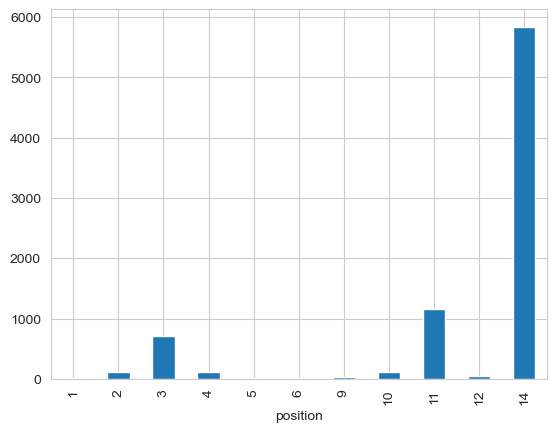

In [5]:
df_localisation.groupby(["lengths", "position"]).size()["GLL"].plot.bar()

In [6]:
df_localisation[df_localisation["lengths"] == "LGL"]

,parva,sub_parva,verse,sub_verse,word,lengths,position
97,1,1,10,c,bahUni,LGL,1
140,1,1,13,e,bhavanta,LGL,1
143,1,1,13,e,bravImi,LGL,9
596,1,1,55,c,jagAma,LGL,1
605,1,1,56,a,gateSu,LGL,9
...,...,...,...,...,...,...,...
809333,18,5,7,e,uvAca,LGL,2
809440,18,5,17,c,viveza,LGL,1
809596,18,5,30,c,nRpasya,LGL,13
809679,18,5,38,c,ihAsti,LGL,2


<AxesSubplot:>

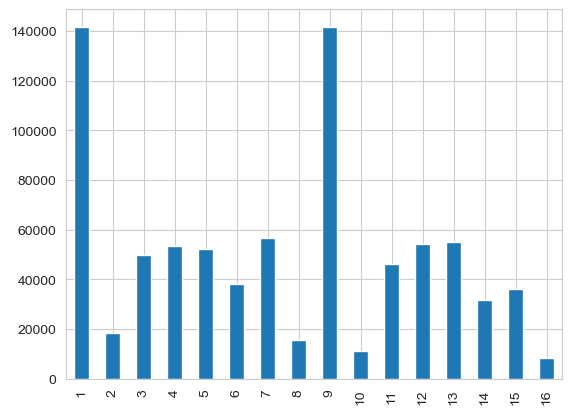

In [7]:
df_localisation["position"].value_counts().sort_index().plot.bar()

In [8]:
import re
def shloka_type(lengths):
    p1, p2, p3, p4 = lengths.split(".")
    if re.match("LGG[LG]", p2):
        return "pathya"
    elif re.match("LLL[LG]", p2):
        if re.match("[LG]GLG", p1):
            return "vipula 2a"
        elif re.match("[LG]LGG", p1):
            return "vipula 2b"
        else:
            return "invalid vipula 2"
    elif re.match("GLL[GL]", p2) and re.match("[LG]GLG", p1):
        return "vipula 3"
    elif re.match("GGG[GL]", p2) and re.match("[LG]GLG", p1):
        return "vipula 4"
    else:
        return "invalid"

<AxesSubplot:xlabel='parva'>

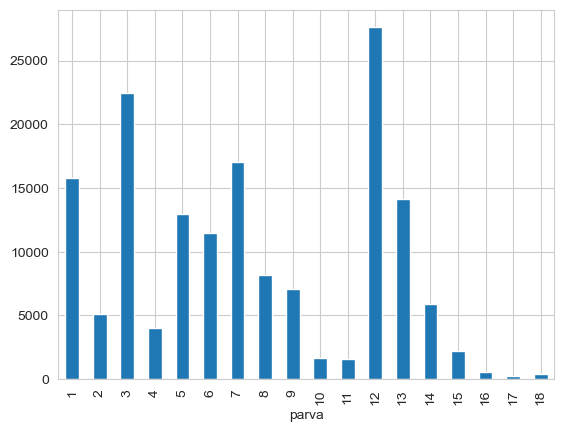

In [37]:
df.groupby("parva").size().plot.bar()

<AxesSubplot:xlabel='Count', ylabel='type'>

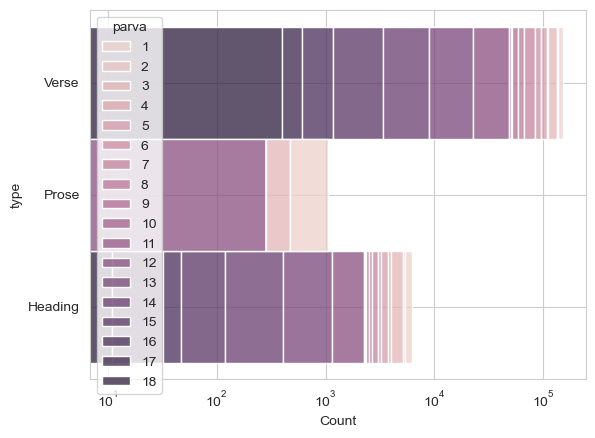

In [27]:
sns.histplot(y="type", data=df, hue="parva", multiple="stack", log_scale=(True, False))

/run/user/1000/ipykernel_319349/3390721909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shlokas["shloka_type"] = shlokas["lengths"].apply(shloka_type)


<AxesSubplot:>

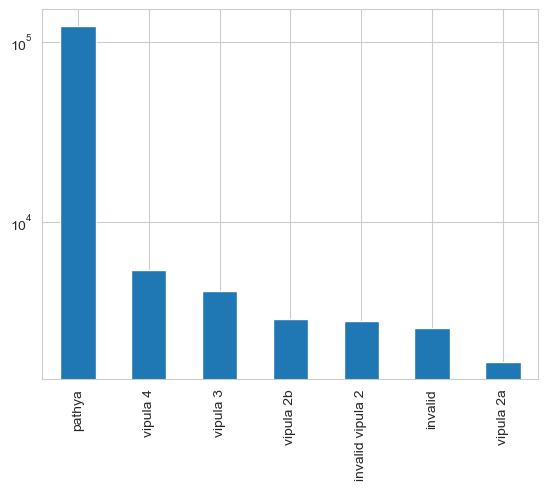

In [9]:
shlokas = df[(df.metre == "Shloka") & (df.type == "Verse")]
shlokas["shloka_type"] = shlokas["lengths"].apply(shloka_type)

shlokas["shloka_type"].value_counts().plot.bar(logy=True)

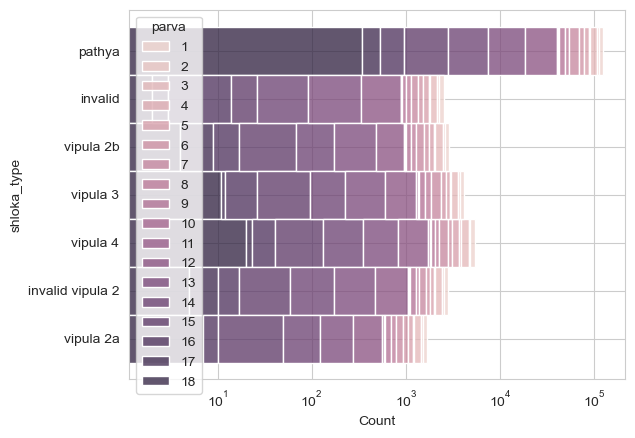

In [24]:
ax = sns.histplot(y="shloka_type", data=shlokas, hue="parva", multiple="stack", log_scale=(True, False))
#ax.set(ylabel='Anzahl Silben', xlabel='Anzahl Verse')
#ax.legend(title="Buch", labels=[1,2,3,4])
#ax.set_yticks(sorted(list(df["syllables"].drop_duplicates().values)))

In [11]:
def get_pada(number):
    assert 1 <= number <= 4
    return lambda ls: ls.split(".")[number - 1]

<AxesSubplot:>

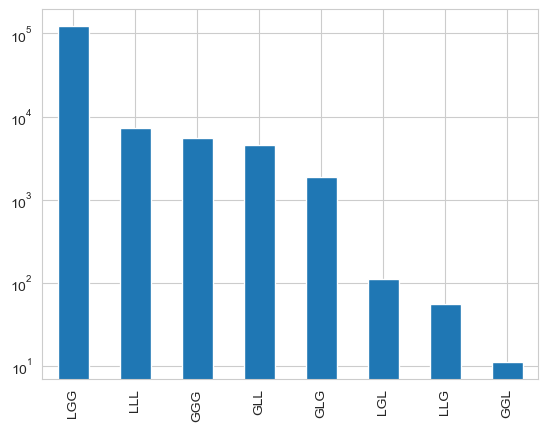

In [12]:
shlokas["lengths"].apply(lambda ls: ls.split(".")[1][0:3]).value_counts().plot.bar(logy=True)

<AxesSubplot:>

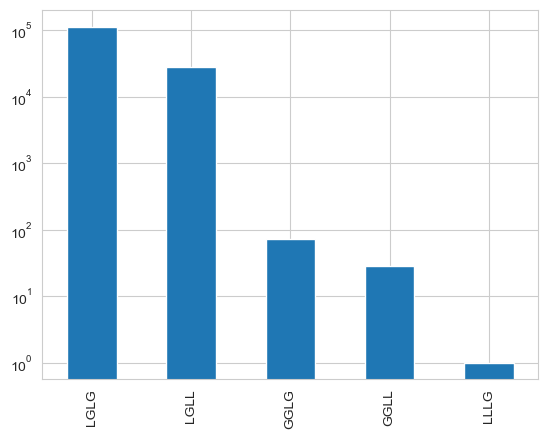

In [13]:
shlokas["lengths"].apply(get_pada(4)).value_counts().plot.bar(logy=True)

In [14]:
shlokas[shlokas["shloka_type"] == "invalid"]

,parva,sub_parva,verse,sub_verse,type,metre,text,syllables,lengths,shloka_type
3,1,1,2,a,Verse,Shloka,samAsInAn abhyagacchad brahmarSIn saMzitavratAn,sa.mA.sI.nA.nabh.ya.gac.chadb.rah.mar.SIn.saM....,LGGG.GLGG.GGGG.LGLG,invalid
26,1,1,12,c,Verse,Shloka,AyuSmantaH sarva eva brahmabhUtA hi me matAH,A.yuS.man.taH.sar.va.e.vab.rah.ma.bhU.tA.hi.me...,GGGG.GLGG.GLGG.LGLG,invalid
379,1,1,185,c,Verse,Shloka,nAtyantam evAnuvRttiH zrUyate putrarakSaNe,nAt.yan.ta.me.vA.nu.vRt.tiHz.rU.ya.te.put.ra.r...,GGLG.GLGG.GLGG.LGLG,invalid
395,1,1,192,a,Verse,Shloka,devarSayo hy atra puNyA brahmarAjarSayas tathA,de.var.Sa.yoh.yat.ra.puN.yAb.rah.ma.rA.jar.Sa....,GGLG.GLGG.GLGG.LGLG,invalid
428,1,1,208,c,Verse,Shloka,samAgataiH surarSibhis tulAm AropitaM purA,sa.mA.ga.taiH.su.rar.Si.bhis.tu.lA.mA.ro.pi.ta...,LGLG.LGLG.LGGG.LGLG,invalid
...,...,...,...,...,...,...,...,...,...,...
157777,16,8,74,a,Verse,Shloka,sa tat kRtvA prAptakAlaM bASpeNApihito 'rjunaH,sa.tat.kRt.vAp.rAp.ta.kA.laM.bAS.pe.NA.pi.hi.t...,LGGG.GLGG.GGGL.LGLG,invalid
157818,16,9,19,c,Verse,Shloka,caturbhujaH pItavAsA zyAmaH padmAyatekSaNaH,ca.tur.bhu.jaH.pI.ta.vA.sAz.yA.maH.pad.mA.ya.t...,LGLG.GLGG.GGGG.LGLG,invalid
157955,17,2,3,c,Verse,Shloka,yAjJasenI bhraSTayogA nipapAta mahItale,yAj.Ja.se.nIbh.raS.Ta.yo.gA.ni.pa.pA.ta.ma.hI....,GLGG.GLGG.LLGL.LGLG,invalid
158140,18,1,24,a,Verse,Shloka,dhRSTadyumnaM sAtyakiM ca dhRSTadyumnasya cAtm...,dhRS.Tad.yum.naM.sAt.ya.kiM.ca.dhRS.Tad.yum.na...,GGGG.GLGL.GGGG.LGLG,invalid


In [15]:
pd.DataFrame(shlokas.groupby("parva")["shloka_type"].value_counts(normalize=True)).unstack()

shloka_type                                                 \
shloka_type     invalid invalid vipula 2    pathya vipula 2a vipula 2b   
parva                                                                    
1              0.021967         0.020693  0.852677  0.011771  0.019868   
2              0.030343         0.023747  0.832894  0.014732  0.028804   
3              0.015226         0.020098  0.860833  0.011014  0.022687   
4              0.014459         0.013302  0.869289  0.006651  0.012146   
5              0.022790         0.019037  0.850174  0.013546  0.021051   
6              0.016343         0.014558  0.884756  0.011083  0.018503   
7              0.013836         0.015009  0.878196  0.009265  0.018221   
8              0.016856         0.017300  0.856720  0.013456  0.022180   
9              0.015226         0.022242  0.873862  0.013136  0.018510   
10             0.009634         0.020552  0.870263  0.011561  0.019268   
11             0.002024         0.018893  0.881242  0.012146  0.016869   
12             0.022174         0.023293  0.860881  0.011587  0.018698   
13             0.018942         0.023737  0.854122  0.011947  0.023737   
14             0.012053         0.020582  0.870573  0.013351  0.019655   
15             0.005679         0.019877  0.856602  0.018457  0.024136   
16             0.022177         0.014113  0.877016  0.006048  0.016129   
17             0.005128         0.025641  0.923077       NaN  0.025641   
18             0.005076         0.012690  0.875635  0.017766  0.010152   

                                 
shloka_type  vipula 3  vipula 4  
parva                            
1            0.029765  0.043260  
2            0.028144  0.041337  
3            0.027965  0.042176  
4            0.026894  0.057259  
5            0.026451  0.046952  
6            0.027238  0.027519  
7            0.032180  0.033292  
8            0.039036  0.034452  
9            0.030751  0.026273  
10           0.023764  0.044958  
11           0.027665  0.041161  
12           0.027368  0.035998  
13           0.029946  0.037570  
14           0.023734  0.040052  
15           0.033128  0.042120  
16           0.028226  0.036290  
17           0.005128  0.015385  
18           0.027919  0.050761

In [16]:
# Vipula 2
shlokas[shlokas["lengths"].apply(lambda ls: get_pada(2)(ls)[0:3] == "LLL")]["lengths"].apply(get_pada(1)).value_counts()

GLGG    1989
GGGG    1539
LGGG    1271
LLGG     891
LGLG     844
GGLG     814
GGGL       3
Name: lengths, dtype: int64

In [17]:
# Pathya
shlokas[shlokas["lengths"].apply(lambda ls: get_pada(2)(ls)[0:3] == "LGG")]["lengths"].apply(get_pada(1)).value_counts()

GLGG    19062
GGGG    15180
LGGG    12438
GLGL    11664
LLGG    11310
GGGL     9321
GGLL     8787
LGGL     8336
LGLL     7311
LGLG     6771
GGLG     6418
LLGL     5630
GLLL        6
GLLG        5
LLLG        2
LLLL        2
Name: lengths, dtype: int64

In [18]:
# Vipula 3
shlokas[shlokas["lengths"].apply(lambda ls: get_pada(2)(ls)[0:3] == "GLL")]["lengths"].apply(get_pada(1)).value_counts()

LGLG    2128
GGLG    1979
GGGG     139
LGGG     108
GLGG      92
LLGG      24
GGGL       4
LLGL       2
GLLG       1
GGLL       1
LLLG       1
Name: lengths, dtype: int64

In [19]:
# Vipula 4
shlokas[shlokas["lengths"].apply(lambda ls: get_pada(2)(ls)[0:3] == "GGG")]["lengths"].apply(get_pada(1)).value_counts()

LGLG    2917
GGLG    2487
GGGG      30
GLGG      23
LGGG      16
LLGG       8
GLGL       8
LLGL       7
GGLL       6
LGGL       3
GGGL       3
LGLL       2
LLLG       1
GLLG       1
Name: lengths, dtype: int64

In [20]:
# Invalid because of [LG]LL[LG] in Pāda 1 or 3
shlokas[shlokas["lengths"].apply(lambda ls: get_pada(1)(ls)[1:3] == "LL" or get_pada(3)(ls)[1:3] == "LL")]

,parva,sub_parva,verse,sub_verse,type,metre,text,syllables,lengths,shloka_type
763,1,2,158,c,Verse,Shloka,adhyAyAnAM zataM proktaM saptadaza tathApare,adh.yA.yA.nAM.za.taMp.rok.taM.sap.ta.da.za.ta....,GGGG.LGGG.GLLL.LGLG,pathya
935,1,2,234,a,Verse,Shloka,etad akhilam AkhyAtaM bhArataM parvasaMgrahAt,e.ta.da.khi.la.mAkh.yA.taM.bhA.ra.taM.par.va.s...,GLLL.LGGG.GLGG.LGLG,pathya
3225,1,39,29,c,Verse,Shloka,yad gRhItaM phalaM rAjJA tatra kRmir abhUd aNuH,yad.gR.hI.taM.pha.laM.rAj.JA.tat.ra.kR.mi.ra.b...,GLGG.LGGG.GLLL.LGLG,pathya
8125,1,99,41,a,Verse,Shloka,katham arAjakaM rASTraM zakyaM dhArayituM prabho,ka.tha.ma.rA.ja.kaM.rAST.raM.zak.yaM.dhA.ra.yi...,LLLG.LGGG.GGGL.LGLG,pathya
11782,1,158,14,a,Verse,Shloka,na kuNapAH zRGgiNo vA na devA na ca mAnuSAH,na.ku.Na.pAH.zRG.gi.No.vA.na.de.vA.na.ca.mA.nu...,LLLG.GLGG.LGGL.LGLG,invalid
16497,2,10,4,a,Verse,Shloka,razmivatI bhAsvarA ca divyagandhA manoramA,raz.mi.va.tI.bhAs.va.rA.ca.div.ya.gan.dhA.ma.n...,GLLG.GLGL.GLGG.LGLG,invalid
17240,2,19,10,a,Verse,Shloka,aparihAryA meghAnAM mAgadheyaM maNeH kRte,a.pa.ri.hAr.yA.me.ghA.nAM.mA.ga.dhe.yaM.ma.NeH...,LLLG.GGGG.GLGG.LGLG,invalid
38051,3,222,36,c,Verse,Shloka,nApi parivade zvazrUM sarvadA pariyantritA,nA.pi.pa.ri.va.dez.vaz.rUM.sar.va.dA.pa.ri.yan...,GLLL.LGGG.GLGL.LGLG,pathya
38057,3,222,39,c,Verse,Shloka,nApi parivade cAhaM tAM pRthAM pRthivIsamAm,nA.pi.pa.ri.va.de.cA.haM.tAM.pR.thAM.pR.thi.vI...,GLLL.LGGG.GLGL.LGLG,pathya
45056,4,29,26,c,Verse,Shloka,vayam api nigRhNImo dvidhA kRtvA varUthinIm,va.ya.ma.pi.ni.gRh.NI.mod.vi.dhA.kRt.vA.va.rU....,LLLL.LGGG.LGGG.LGLG,pathya
